# A Density modeling

In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

## A.1 Implement a convolutional VAE

BASELINE VAE

In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()       
        
        ### Encoder layers
        self.fc_enc1 = nn.Linear(784, 400)
        self.fc_enc2 = nn.Linear(400, 100)
        self.fc_enc3 = nn.Linear(100, 2*latent_dim) # Note we return 2*latent_dim
        
        ### Decoder layers
        self.fc_dec1 = nn.Linear(latent_dim, 100)
        self.fc_dec2 = nn.Linear(100,400)
        self.fc_dec3 = nn.Linear(400,784)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = eps * std + mu
        return z

    def encode(self, x):
        x = self.fc_enc1(x)
        x = F.relu(x)
        x = self.fc_enc2(x)
        x = F.relu(x)
        x = self.fc_enc3(x)

        mu, logvar = torch.chunk(x, 2, dim=1)
        return mu, logvar

    def decode(self, z):
        layer1 = self.fc_dec1(z)
        activation1 = F.relu(layer1)
        layer2 = self.fc_dec2(activation1)
        activation2 = F.relu(layer2)
        layer3 = self.fc_dec3(activation2)
        xHat = torch.sigmoid(layer3)
        
        return xHat
    
    def forward(self, x):
        
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        xHat = self.decode(z)
        
        return xHat, mu, logvar

C-VAE

In [ ]:
class VAE_conv(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE_conv, self).__init__()       
        
        ### Encoder layers
        self.conv_enc1 = nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1)
        self.conv_enc2 = nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1)
        self.conv_enc3 = nn.Conv2d(64, 64, kernel_size=4, stride=1, padding=1)
        self.fc_enc4 = nn.Linear(2304, 400)
        self.fc_enc5 = nn.Linear(400, 2*latent_dim)
        
        ### Decoder layers
        self.fc_dec1 = nn.Linear(latent_dim, 400)
        self.fc_dec2 = nn.Linear(400, 2304)
        self.upconv_dec3 = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=1, padding=1)
        self.upconv_dec4 = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1)
        self.upconv_dec5 = nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1)
        

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = eps * std + mu
        return z

    def encode(self, x):
        x = self.conv_enc1(x)
        x = F.relu(x)
        x = self.conv_enc2(x)
        x = F.relu(x)
        x = self.conv_enc3(x)
        x = F.relu(x)
        x = x.view(-1, 2304)
        x = self.fc_enc4(x)
        x = F.relu(x)
        x = self.fc_enc5(x)

        mu, logvar = torch.chunk(x, 2, dim=1)
        return mu, logvar

    def decode(self, z):
        z = self.fc_dec1(z)
        z = F.relu(z)
        z = self.fc_dec2(z)
        z = F.relu(z)
        z = z.view(-1, 64, 6, 6)
        z = self.upconv_dec3(z)
        z = F.relu(z)
        z = self.upconv_dec4(z)
        z = F.relu(z)
        z = self.upconv_dec5(z)
        
        xHat = torch.sigmoid(z)
        
        return xHat
    
    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 1, 28, 28))
        z = self.reparameterize(mu, logvar)
        xHat = self.decode(z)
        xHat = xHat.view(-1, 784)
        return xHat, mu, logvar

In [ ]:
cuda2 = True # torch.cuda.is_available() can be used to check if a gpu is available - I just set it to False
batch_size2 = 128
log_interval2 = 10
epochs2 = 20

torch.manual_seed(1) # args.seed

device = torch.device("cuda" if cuda2 else "cpu") # args.cuda
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda2 else {} # args.cuda

# Get train and test data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size2, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size2, shuffle=True, **kwargs)

In [ ]:
# Define VAE model

model_lin = VAE().to(device)
model_conv = VAE_conv().to(device)
optimizer_lin = optim.Adam(model_lin.parameters(), lr=1e-3)
optimizer_conv = optim.Adam(model_conv.parameters(), lr=1e-3)


# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD # -ELBO


def train(epoch, model, optimizer):
    model.train() # so that everything has gradients and we can do backprop and so on...
    train_loss = 0
    for batch_idx, (data, _) in tqdm(enumerate(train_loader), total=60000//128 + 1):
        data = data.to(device)
        optimizer.zero_grad() # "reset" gradients to 0 for text iteration
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward() # calc gradients
        train_loss += loss.item()
        optimizer.step() # backpropagation

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch, model):
    model.eval()
    test_loss = 0
    with torch.no_grad(): # no_grad turns of gradients...
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

print("Training and evaluating linear model:\n")
for epoch in range(1, epochs2 + 1):
    train(epoch, model_lin, optimizer_lin)
    test(epoch, model_lin)

    
print("Training and evaluating conv model:\n")
for epoch in range(1, epochs2 + 1):
    train(epoch, model_conv, optimizer_conv)
    test(epoch, model_conv)

In [ ]:
all_data = []
all_labels = []

for i, (data, y) in enumerate(test_loader):
    all_data.append(data)
    all_labels.append(y)

In [ ]:
all_test_data = torch.cat(all_data).to(device)
all_test_labels = torch.cat(all_labels).to(device)

In [ ]:
_, mu_lin, _ = model_lin(all_test_data)
_, mu_conv, _ = model_conv(all_test_data)

In [ ]:
mu_cpu_lin = mu_lin.detach().cpu()
mu_cpu_conv = mu_conv.detach().cpu()

In [ ]:
k = 15

ax1 = torch.linspace(-2.33, 2.33, k)
ax2 = torch.linspace(-2.33, 2.33, k)
pos_x, pos_y = torch.meshgrid(ax1, ax2)
sample_pos = torch.vstack([pos_x.flatten(), pos_y.flatten()]).T

In [ ]:
sample_pos.shape

torch.Size([225, 2])

In [ ]:
sample_lin = model_lin.decode(sample_pos.to(device)).cpu()
imgs_lin = sample_lin.view(k**2, 28, 28)

sample_conv = model_conv.decode(sample_pos.to(device)).cpu()
imgs_conv = sample_conv.view(k**2, 28, 28)

In [ ]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.pyplot as plt

In [ ]:
imgs_lin = imgs_lin.detach().cpu().numpy()
imgs_conv = imgs_conv.detach().cpu().numpy()

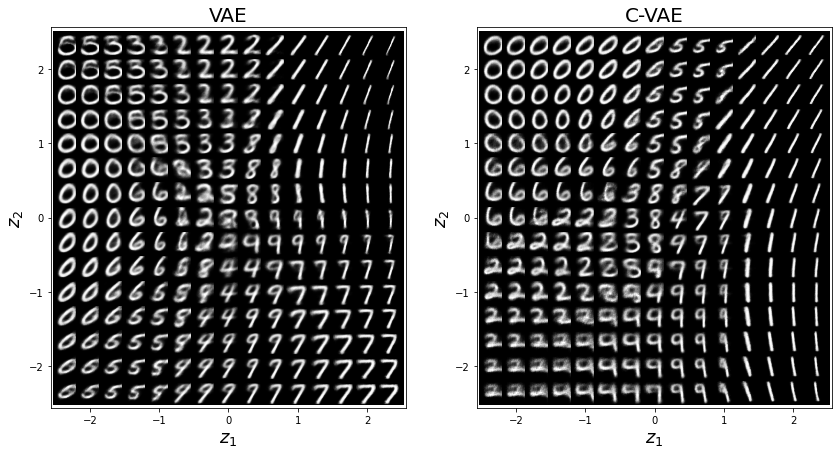

In [ ]:
x, y = sample_pos[:, 0], sample_pos[:, 1]
fig, (ax_lin, ax_conv) = plt.subplots(1, 2, figsize=(14, 7))
ax_lin.scatter(x, y) 
ax_conv.scatter(x, y) 
ax_lin.tick_params(axis='both', which='major', labelsize=10)

i = 0
for x0, y0 in zip(x, y):
    ab_lin = AnnotationBbox(OffsetImage(imgs_lin[i], 1, cmap='gray'), (x0, y0), frameon=False)
    ab_conv = AnnotationBbox(OffsetImage(imgs_conv[i], 1, cmap='gray'), (x0, y0), frameon=False)
    ax_lin.add_artist(ab_lin)
    ax_conv.add_artist(ab_conv)
    i+=1

ax_lin.set_title('VAE', fontsize=20)
ax_conv.set_title('C-VAE', fontsize=20)

for ax in (ax_lin, ax_conv):
    ax.set_xlabel('$z_1$', fontsize=18)
    ax.set_ylabel('$z_2$', fontsize=18)

In [ ]:
def DICE(pred, true):
  TP = torch.sum(torch.logical_and(pred ==1, true == 1))
  FP = torch.sum(torch.logical_and(pred == 1, true == 0))
  FN = torch.sum(torch.logical_and(pred == 0, true == 1))
  return (2 * TP) / (2 * TP + FP + FN)

In [ ]:
for model, mu in [(model_lin, mu_lin), (model_conv, mu_conv)]:
    decoded_imgs = model.decode(mu)

    dice_true = all_test_data.reshape(10000, -1)
    dice_pred = decoded_imgs.view(-1, 784)

    total_dice = 0

    for i in range(10000):
        res = DICE(dice_pred[i] > 0.5, dice_true[i] > 0.5)
        total_dice += res

    print(total_dice/10000)

tensor(0.6963, device='cuda:0')
tensor(0.7040, device='cuda:0')


In [ ]:
#torch.save(model_lin.state_dict(), '/content/drive/MyDrive/PML - exam/VAE.pt')
#torch.save(model_conv.state_dict(), '/content/drive/MyDrive/PML - exam/CVAE.pt')

## A.2 Alternative models

### DDPM

This model is inspired by code from
https://medium.com/mlearning-ai/enerating-images-with-ddpms-a-pytorch-implementation-cef5a2ba8cb1

In [ ]:
import random
import imageio
import numpy as np
from argparse import ArgumentParser

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader

from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.datasets.mnist import MNIST, FashionMNIST

In [ ]:
transform = Compose([
    ToTensor(),
    Lambda(lambda x: (x - 0.5) * 2)]
)

train_loader_DDPM = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transform),
    batch_size=128, shuffle=True, **kwargs)
test_loader_DDPM = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transform),
    batch_size=128, shuffle=True, **kwargs)

In [ ]:
class DDPM(nn.Module):
    def __init__(self, network, n_steps, min_beta=10 ** -4, max_beta=0.02, device=None, image_chw=(1, 28, 28)):
        super(DDPM, self).__init__()
        self.n_steps = n_steps
        self.device = device
        self.image_chw = image_chw
        self.network = network.to(device)
        self.betas = torch.linspace(min_beta, max_beta, n_steps).to(
            device)  
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))]).to(device)

    def forward(self, x0, t, eta=None):
        n, _, _, _ = x0.shape
        a_bar = self.alpha_bars[t]

        if eta is None:
            eta = torch.randn(*x0.shape).to(self.device)

        noisy = a_bar.sqrt().reshape(n, 1, 1, 1) * x0 + (1 - a_bar).sqrt().reshape(n, 1, 1, 1) * eta
        return noisy

    def backward(self, x, t):
        return self.network(x, t)

In [ ]:
def sinusoidal_embedding(n, d):
    embedding = torch.tensor([[i / 10_000 ** (2 * j / d) for j in range(d)] for i in range(n)])
    sin_mask = torch.arange(0, n, 2)

    embedding[sin_mask] = torch.sin(embedding[sin_mask])
    embedding[1 - sin_mask] = torch.cos(embedding[sin_mask])

    return embedding

In [ ]:
class Block(nn.Module):
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding=1, activation=None, normalize=True):
        super(Block, self).__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size, stride, padding)
        self.activation = nn.SiLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        out = self.ln(x) if self.normalize else x
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)
        return out

In [ ]:
class UNET(nn.Module):
    def __init__(self, n_steps=1000, time_emb_dim=100):
        super(UNET, self).__init__()

        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        self.te1 = self._make_te(time_emb_dim, 1)
        self.b1 = nn.Sequential(
            Block((1, 28, 28), 1, 10),
            Block((10, 28, 28), 10, 10),
            Block((10, 28, 28), 10, 10)
        )
        self.down1 = nn.Conv2d(10, 10, 4, 2, 1)

        self.te2 = self._make_te(time_emb_dim, 10)
        self.b2 = nn.Sequential(
            Block((10, 14, 14), 10, 20),
            Block((20, 14, 14), 20, 20),
            Block((20, 14, 14), 20, 20)
        )
        self.down2 = nn.Conv2d(20, 20, 4, 2, 1)

        self.te3 = self._make_te(time_emb_dim, 20)
        self.b3 = nn.Sequential(
            Block((20, 7, 7), 20, 40),
            Block((40, 7, 7), 40, 40),
            Block((40, 7, 7), 40, 40)
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(40, 40, 2, 1),
            nn.SiLU(),
            nn.Conv2d(40, 40, 4, 2, 1)
        )

        self.te_mid = self._make_te(time_emb_dim, 40)
        self.b_mid = nn.Sequential(
            Block((40, 3, 3), 40, 20),
            Block((20, 3, 3), 20, 20),
            Block((20, 3, 3), 20, 40)
        )

        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(40, 40, 4, 2, 1),
            nn.SiLU(),
            nn.ConvTranspose2d(40, 40, 2, 1)
        )

        self.te4 = self._make_te(time_emb_dim, 80)
        self.b4 = nn.Sequential(
            Block((80, 7, 7), 80, 40),
            Block((40, 7, 7), 40, 20),
            Block((20, 7, 7), 20, 20)
        )

        self.up2 = nn.ConvTranspose2d(20, 20, 4, 2, 1)
        self.te5 = self._make_te(time_emb_dim, 40)
        self.b5 = nn.Sequential(
            Block((40, 14, 14), 40, 20),
            Block((20, 14, 14), 20, 10),
            Block((10, 14, 14), 10, 10)
        )

        self.up3 = nn.ConvTranspose2d(10, 10, 4, 2, 1)
        self.te_out = self._make_te(time_emb_dim, 20)
        self.b_out = nn.Sequential(
            Block((20, 28, 28), 20, 10),
            Block((10, 28, 28), 10, 10),
            Block((10, 28, 28), 10, 10, normalize=False)
        )

        self.conv_out = nn.Conv2d(10, 1, 3, 1, 1)

    def forward(self, x, t):
        t = self.time_embed(t)
        n = len(x)
        out1 = self.b1(x + self.te1(t).reshape(n, -1, 1, 1))
        out2 = self.b2(self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1))
        out3 = self.b3(self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1))

        out_mid = self.b_mid(self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1))

        out4 = torch.cat((out3, self.up1(out_mid)), dim=1)
        out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1))

        out5 = torch.cat((out2, self.up2(out4)), dim=1)
        out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1))

        out = torch.cat((out1, self.up3(out5)), dim=1)
        out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1))

        out = self.conv_out(out)

        return out

    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.SiLU(),
            nn.Linear(dim_out, dim_out)
        )

In [ ]:
n_steps = 1000
ddpm = DDPM(UNET(n_steps), n_steps=n_steps, min_beta=1e-4, max_beta=0.02, device=device)

In [ ]:
def train_DDPM(ddpm, loader, n_epochs, optim, device):
    mse = nn.MSELoss()
    best_loss = float("inf")
    n_steps = ddpm.n_steps

    for epoch in tqdm(range(n_epochs), desc=f"Training progress"):
        epoch_loss = 0.0
        for step, batch in tqdm(enumerate(train_loader_DDPM), total=60000//128 + 1):
            x0 = batch[0].to(device)
            n = len(x0)

            eta = torch.randn_like(x0).to(device)
            t = torch.randint(0, n_steps, (n,)).to(device)

            noisy_imgs = ddpm(x0, t, eta)

            eta_theta = ddpm.backward(noisy_imgs, t.reshape(n, -1))

            loss = mse(eta_theta, eta)
            optim.zero_grad()
            loss.backward()
            optim.step()

            epoch_loss += loss.item() * len(x0) / len(loader.dataset)


        log_string = f"Loss at epoch {epoch + 1}: {epoch_loss:.3f}"

        # store model
        
        '''
        if best_loss > epoch_loss:
            best_loss = epoch_loss
            torch.save(ddpm.state_dict(), '/content/drive/MyDrive/PML - exam/ddpm_model_500.pt')
            log_string += " Model saved"
        '''

        print(log_string)

In [ ]:
train_DDPM(ddpm, train_loader_DDPM, 20, optim=Adam(ddpm.parameters(), 1e-3), device=device)
#ddpm.load_state_dict(torch.load('/content/drive/MyDrive/PML - exam/ddpm_model.pt'))

<All keys matched successfully>

In [ ]:
all_data = []
all_labels = []

for i, (data, y) in enumerate(test_loader_DDPM):
    all_data.append(data)
    all_labels.append(y)

all_test_data = torch.cat(all_data).to(device)
all_test_labels = torch.cat(all_labels).to(device)

In [ ]:
random_idxs = torch.randperm(len(all_test_data))[:225]

In [ ]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.pyplot as plt

In [ ]:
img_og = all_test_data[random_idxs].to(device)
n = len(img_og)

eta = torch.randn_like(img_og).to(device)

t = ddpm.n_steps - 1
ts = torch.ones((225,), dtype=torch.int64).to(device) * t

noisy_imgs = ddpm(img_og, ts, eta)




In [ ]:
# Set to False if you want to sample from noisy images, and True if you want to sample from noise
sampling = True

with torch.no_grad():
    if device is None:
        device = ddpm.device

    if sampling:
        x = torch.randn(*img_og.shape).to(device)
    else:
        x = torch.clone(noisy_imgs)

    for t in list(range(ddpm.n_steps))[::-1]:

        time_tensor = (torch.ones(x.shape[0], 1) * t).to(device).long()
        eta_theta = ddpm.backward(x, time_tensor)

        alpha_t = ddpm.alphas[t]
        alpha_t_bar = ddpm.alpha_bars[t]

        x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eta_theta)

        if t > 0:
            z = torch.randn(*x.shape).to(device)

    
            beta_t = ddpm.betas[t]
            sigma_t = beta_t.sqrt()
            x = x + sigma_t * z

img_after = torch.clone(x)

In [ ]:
k = 15

ax1 = torch.linspace(-2.33, 2.33, k)
ax2 = torch.linspace(-2.33, 2.33, k)
pos_x, pos_y = torch.meshgrid(ax1, ax2)
sample_pos = torch.vstack([pos_x.flatten(), pos_y.flatten()]).T

(225, 28, 28)


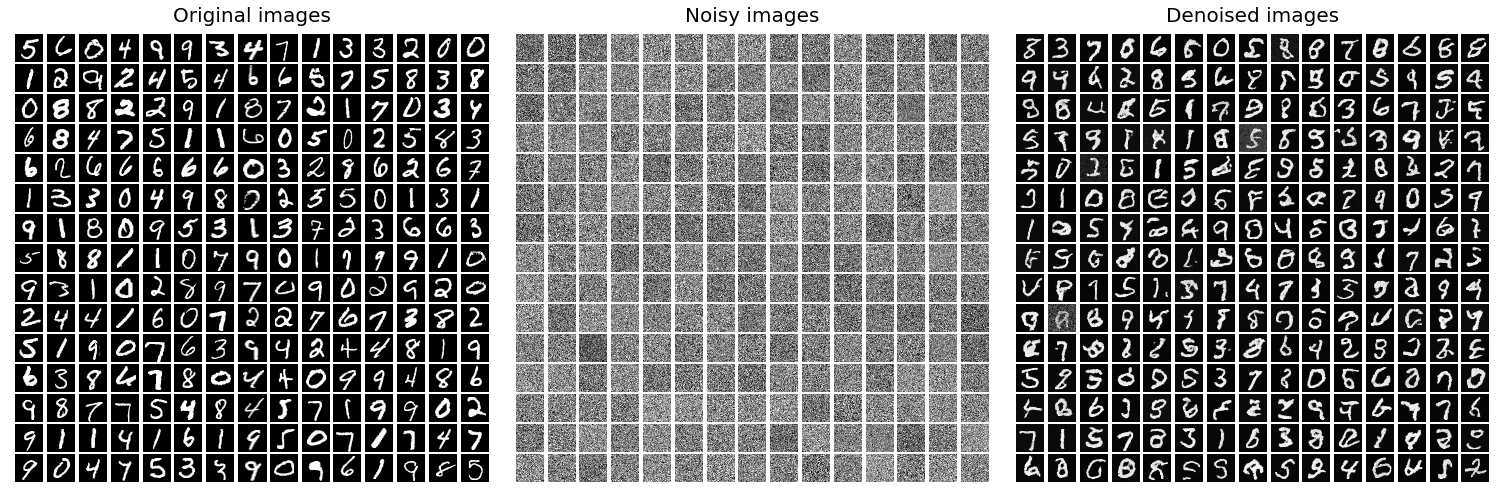

In [ ]:
all_imgs = [img_og, noisy_imgs, img_after]
all_imgs = list(map(lambda img: torch.squeeze(img).detach().cpu().numpy(), all_imgs))

print(all_imgs[1].shape)
x, y = sample_pos[:, 0], sample_pos[:, 1]
fig, axs = plt.subplots(1, 3, figsize=(21, 7))

for ax in axs:
    ax.scatter(x, y) 

for i, ax in enumerate(axs):
    for j, (x0, y0) in enumerate(zip(x, y)):
        ab = AnnotationBbox(OffsetImage(all_imgs[i][j], 1, cmap='gray'), (x0, y0), frameon=False)
        ax.add_artist(ab)


axs[0].set_title('Original images', fontsize=20)
axs[1].set_title('Noisy images', fontsize=20)
axs[2].set_title('Denoised images', fontsize=20)

for ax in axs:
    ax.axis('off')

plt.tight_layout()

[]

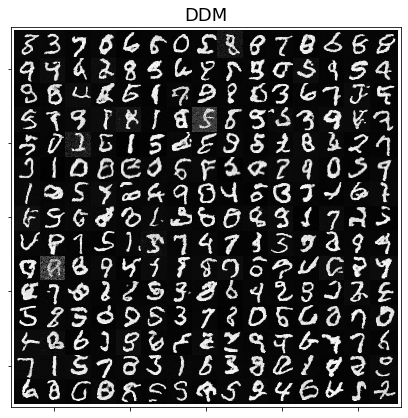

In [ ]:
img_after = torch.squeeze(img_after).detach().cpu().numpy()

x, y = sample_pos[:, 0], sample_pos[:, 1]
fig, ax = plt.subplots(1, 1, figsize=(7, 7))


ax.scatter(x, y) 

for i, (x0, y0) in enumerate(zip(x, y)):
    ab = AnnotationBbox(OffsetImage(img_after[i], 1, cmap='gray'), (x0, y0), frameon=False)
    ax.add_artist(ab)

ax.set_title('DDM', fontsize=18) #Generated images, $t = 1000$
ax.set_xticklabels([])
ax.set_yticklabels([])

In [ ]:
def DICE(pred, true):
  TP = torch.sum(torch.logical_and(pred ==1, true == 1))
  FP = torch.sum(torch.logical_and(pred == 1, true == 0))
  FN = torch.sum(torch.logical_and(pred == 0, true == 1))
  return (2 * TP) / (2 * TP + FP + FN)

In [ ]:
img_after = torch.tensor(img_after).to(device)

<ipython-input-64-788e04991810>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_after = torch.tensor(img_after).to(device)


In [ ]:
dice_true = torch.reshape(img_og, (-1, 784))
dice_pred = torch.reshape(img_after, (-1, 784))

total_dice = 0
N = len(dice_true)

for i in range(N):
    res = DICE(dice_pred[i] > 0.5, dice_true[i] > 0.5)
    total_dice += res

print(total_dice/N)

tensor(0.0936, device='cuda:0')


- average dice for 100 steps: 0.7452
- aveage dice for 1000 steps: 0.0986

## Bayesian VAE

In [ ]:
%%capture
!pip install torchbnn

In [ ]:
from torchbnn.modules.linear import BayesLinear

In [ ]:
class BAYESVAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(BAYESVAE, self).__init__()       
        
        ### Encoder layers
        self.fc_enc1 = nn.Linear(784, 400)
        self.fc_enc2 = nn.Linear(400, 100)
        self.fc_enc3 = nn.Linear(100, 2*latent_dim) # Note we return 2*latent_dim
        
        ### Decoder layers
        self.fc_dec1 = BayesLinear(prior_mu=0.0, prior_sigma=0.1, in_features=latent_dim, out_features=100)
        self.fc_dec2 = BayesLinear(prior_mu=0.0, prior_sigma=0.1, in_features=100, out_features=400)
        self.fc_dec3 = BayesLinear(prior_mu=0.0, prior_sigma=0.1, in_features=400, out_features=784)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = eps * std + mu
        return z

    def encode(self, x):
        x = self.fc_enc1(x)
        x = F.relu(x)
        x = self.fc_enc2(x)
        x = F.relu(x)
        x = self.fc_enc3(x)

        mu, logvar = torch.chunk(x, 2, dim=1)
        return mu, logvar

    def decode(self, z):
        layer1 = self.fc_dec1(z)
        activation1 = F.relu(layer1)
        layer2 = self.fc_dec2(activation1)
        activation2 = F.relu(layer2)
        layer3 = self.fc_dec3(activation2)
        xHat = torch.sigmoid(layer3)
        
        return xHat
    
    def forward(self, x):
        
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        xHat = self.decode(z)
        
        return xHat, mu, logvar

In [ ]:
# Define VAE model

model = BAYESVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD # -ELBO


def train(epoch, model, optimizer):
    model.train() # so that everything has gradients and we can do backprop and so on...
    train_loss = 0
    for batch_idx, (data, _) in tqdm(enumerate(train_loader), total=60000//128 + 1):
        data = data.to(device)
        optimizer.zero_grad() # "reset" gradients to 0 for text iteration
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward() # calc gradients
        train_loss += loss.item()
        optimizer.step() # backpropagation

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch, model):
    model.eval()
    test_loss = 0
    with torch.no_grad(): # no_grad turns of gradients...
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))


print("Training and evaluating BAYESIAN VAE:\n")
for epoch in range(1, epochs2 + 1):
    train(epoch, model, optimizer)
    test(epoch, model)


In [ ]:
k = 15

ax1 = torch.linspace(-2.33, 2.33, k)
ax2 = torch.linspace(-2.33, 2.33, k)
pos_x, pos_y = torch.meshgrid(ax1, ax2)
sample_pos = torch.vstack([pos_x.flatten(), pos_y.flatten()]).T

In [ ]:
sample = model.decode(sample_pos.to(device)).cpu()
imgs = sample.view(k**2, 28, 28)

In [ ]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.pyplot as plt

In [ ]:
imgs = imgs.detach().cpu().numpy()

In [ ]:
img_after = torch.squeeze(img_after).detach().cpu().numpy()

x, y = sample_pos[:, 0], sample_pos[:, 1]
fig, ax = plt.subplots(1, 1, figsize=(7, 7))


ax.scatter(x, y) 

for i, (x0, y0) in enumerate(zip(x, y)):
    ab = AnnotationBbox(OffsetImage(img_after[i], 1, cmap='gray'), (x0, y0), frameon=False)
    ax.add_artist(ab)

ax.set_title('Generated images, $t = 1000$', fontsize=18)
ax.axis('off')

plt.tight_layout()

Text(0, 0.5, '$z_2$')

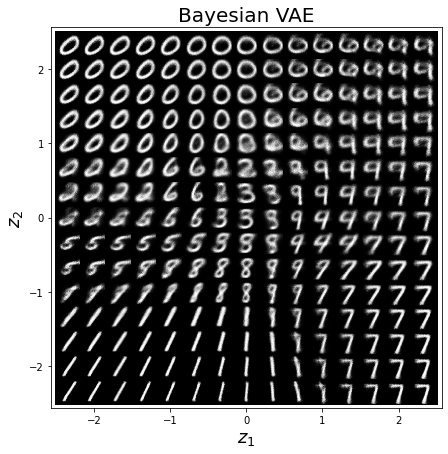

In [ ]:
x, y = sample_pos[:, 0], sample_pos[:, 1]
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.scatter(x, y) 

i = 0
for x0, y0 in zip(x, y):
    ab = AnnotationBbox(OffsetImage(imgs[i], 1, cmap='gray'), (x0, y0), frameon=False)
    ax.add_artist(ab)
    i+=1

ax.set_title('Bayesian VAE', fontsize=18)
ax.set_xlabel('$z_1$', fontsize=18)
ax.set_ylabel('$z_2$', fontsize=18)

## PPCA

In [ ]:
mnist_train_PPCA = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_test_PPCA = datasets.MNIST(root='./data', train=False, download=True, transform=None)

In [ ]:
#Number of samples
N = len(mnist_train_PPCA)

#Make data into af vector
data_vec = torch.reshape(mnist_train_PPCA.data, (60000, 28*28))

#Estimate the data coviarance matrix and eigenvalues
data_cov = torch.cov(data_vec.T)
data_eig = torch.linalg.eig(data_cov)

#Calculate W
D = data_eig.eigenvectors.shape[1]
M = 2
sig_sq = 1/(D-M)*torch.sum(data_eig.eigenvalues[2:])

U_M = data_eig.eigenvectors[:,:2]
L_M = torch.diag(data_eig.eigenvalues[:2])

W = torch.matmul(U_M, (L_M-sig_sq*torch.eye(2))**0.5)

#Calculate mu
data_vec_double = data_vec.type(torch.DoubleTensor)
mu = torch.mean(data_vec_double, 0)

In [ ]:
#Evaluate expected values of Z (to get ranges for the mesh grid)
M = torch.matmul(W.T, W) + sig_sq * torch.eye(2)
x_mu = data_vec_double.T - mu.repeat(N,1).T
temp = torch.inverse(M)@W.T
temp_double = temp.type(torch.double)
z_values = temp_double@x_mu

results_for_plot = z_values.detach().numpy().T

<ipython-input-8-19847d1c087e>:5: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:250.)
  temp_double = temp.type(torch.double)


In [ ]:
k = 15

#Ranges are found looking at max and min values in "results_for_plot"
ax1 = torch.linspace(-4, 2, k)
ax2 = torch.linspace(-3,3, k)
pos_x, pos_y = torch.meshgrid(ax1, ax2)
sample_pos = torch.vstack([pos_x.flatten(), pos_y.flatten()]).T

/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
sample_ppca = []

#Loop over sample positions
for i in range(sample_pos.shape[0]):
  sample_ppca.append(W.type(torch.double) @ torch.tensor(sample_pos[i]).reshape(2,1).type(torch.double) + mu.reshape(784,1))

#sample_ppca = np.array(sample_ppca)
imgs_ppca = np.concatenate(sample_ppca).reshape(-1, 28, 28)

<ipython-input-10-747f5194bd52>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_ppca.append(W.type(torch.double) @ torch.tensor(sample_pos[i]).reshape(2,1).type(torch.double) + mu.reshape(784,1))


Text(0, 0.5, '$z_2$')

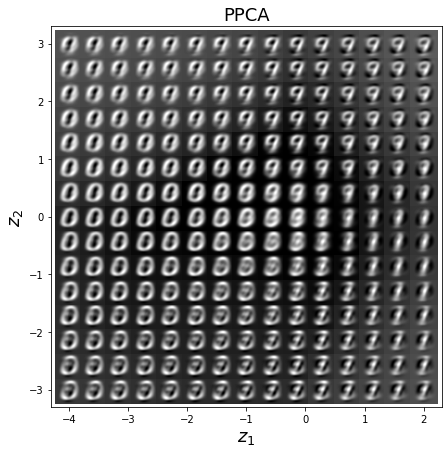

In [ ]:
x, y = sample_pos[:, 0], sample_pos[:, 1]
fig, ax_ppca = plt.subplots(1, 1, figsize=(7,7))
ax_ppca.scatter(x, y) 
ax_ppca.tick_params(axis='both', which='major', labelsize=10)

i = 0
for x0, y0 in zip(x, y):
    ab_ppca = AnnotationBbox(OffsetImage(imgs_ppca[i], 1, cmap='gray'), (x0, y0), frameon=False)
    ax_ppca.add_artist(ab_ppca)
    i+=1

ax_ppca.set_title('PPCA', fontsize=18)

ax_ppca.set_xlabel('$z_1$', fontsize=18)
ax_ppca.set_ylabel('$z_2$', fontsize=18)

## Compare models

In [ ]:
device = 'cuda'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### VAE

In [ ]:
model_vae = VAE().to(device)
model_vae.load_state_dict(torch.load("/content/drive/MyDrive/PML - exam/VAE.pt"))
model_vae.eval();

In [ ]:
latent_samples = (torch.rand(size=(10000, 2)) * 4.66 - 2.33).to(device)
vae_out = model_vae.decode(latent_samples)
vae_out = vae_out.view(-1, 28, 28)

### C-VAE

In [ ]:
model_cvae = VAE_conv().to(device)
model_cvae.load_state_dict(torch.load("/content/drive/MyDrive/PML - exam/CVAE.pt"))
model_cvae.eval();

In [ ]:
latent_samples = (torch.rand(size=(10000, 2)) * 4.66 - 2.33).to(device)
cvae_out = model_cvae.decode(latent_samples)
cvae_out = cvae_out.view(-1, 28, 28)

### B-VAE

In [ ]:
model_bvae = BAYESVAE().to(device)
model_bvae.load_state_dict(torch.load("/content/drive/MyDrive/PML - exam/BVAE.pt"))
model_bvae.eval();

In [ ]:
latent_samples = (torch.rand(size=(10000, 2)) * 4.66 - 2.33).to(device)
bvae_out = model_bvae.decode(latent_samples)
bvae_out = bvae_out.view(-1, 28, 28)

### DDPM

In [ ]:
n_steps = 1000
model_ddpm = DDPM(UNET(n_steps), n_steps=n_steps, min_beta=1e-4, max_beta=0.02, device=device)
model_ddpm.load_state_dict(torch.load("/content/drive/MyDrive/PML - exam/ddpm_model.pt"))
model_ddpm.eval();

In [ ]:
all_samples = []
with torch.no_grad():
    for i in tqdm(range(100)):
        samples = torch.randn(100, 1, 28, 28).to(device)

        for t in list(range(model_ddpm.n_steps))[::-1]:

            time_tensor = (torch.ones(samples.shape[0], 1) * t).to(device).long()
            eta_theta = model_ddpm.backward(samples, time_tensor)

            alpha_t = model_ddpm.alphas[t]
            alpha_t_bar = model_ddpm.alpha_bars[t]

            samples = (1 / alpha_t.sqrt()) * (samples - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eta_theta)

            if t > 0:
                z = torch.randn(*samples.shape).to(device)
                beta_t = model_ddpm.betas[t]
                sigma_t = beta_t.sqrt()
                samples += sigma_t * z
        all_samples.append(samples.detach())

### PPCA

In [ ]:
x_lims = [-4, 2]
y_lims = [-3, 2]

points = np.random.uniform(low=[x_lims[0], y_lims[1]], high=[x_lims[1], y_lims[0]], size=(10000, 2))

In [ ]:
sample_ppca = []

for i in range(len(points)):
  sample_ppca.append(W.type(torch.double) @ torch.tensor(points[i]).reshape(2,1).type(torch.double) + mu.reshape(784,1))

#sample_ppca = np.array(sample_ppca)
imgs_ppca = np.concatenate(sample_ppca).reshape(-1, 28, 28)

### Calculate FID scores

In [ ]:
!pip install fid-score

In [ ]:
all_samples = torch.cat(all_samples, dim=0)

In [ ]:
transform = Compose([
    ToTensor(),
    Lambda(lambda x: (x - 0.5) * 2)]
)

test_loader_DDPM = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transform),
    batch_size=10000, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=10000, shuffle=True, **kwargs)

In [ ]:
all_gen_tensors = [vae_out, cvae_out, bvae_out, all_samples[:, 0, ...]]


all_array = [gen.detach().cpu().numpy() for gen in all_gen_tensors]

for data, _ in test_loader:
    all_array.append(data.numpy()[:, 0, ...])
    break

for data, _ in test_loader_DDPM:
    all_array.append(data.numpy()[:, 0, ...])
    break

In [ ]:
all_array.insert(4, imgs_ppca)
#all_array = np.load("/content/drive/MyDrive/all_fid/all_data.npy")

In [ ]:
from PIL import Image

for i, m_type in enumerate(["vae", "cvae", "bvae", "ddpm", "ppca"]):
    if i < 4:
        continue
    for j in tqdm(range(10000)):
        curr_arr = all_array[i][j]
        normalized_array = (255 * (curr_arr - curr_arr.min()) / (curr_arr.max() - curr_arr.min())).astype(np.uint8)
        normalized_array = np.repeat(normalized_array[:, :, np.newaxis], 3, axis=2)

        img = Image.fromarray(normalized_array)
        img.save(f"/content/drive/MyDrive/all_fid/{m_type}_imgs/{j}.png")

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
for i, o_type in enumerate(["vae", "ddpm"]):
    for j in tqdm(range(10000)):
        curr_arr = all_array[i + 5][j]
        normalized_array = (255 * (curr_arr - curr_arr.min()) / (curr_arr.max() - curr_arr.min())).astype(np.uint8)
        normalized_array = np.repeat(normalized_array[:, :, np.newaxis], 3, axis=2)

        img = Image.fromarray(normalized_array)
        img.save(f"/content/drive/MyDrive/all_fid/{o_type}_origs/{j}.png")

100%|██████████| 10000/10000 [00:23<00:00, 432.15it/s]


In [ ]:
vae_fids = []
cvae_fids = []
bvae_fids = []
ddpm_fids = []
ppca_fids = []

In [ ]:
fid = FidScore(paths, device, batch_size)

score = fid.calculate_fid_score()

In [ ]:
for i in range(10):
    fid = FidScore(["/content/drive/MyDrive/all_fid/vae_origs", 
                    "/content/drive/MyDrive/all_fid/vae_imgs"], device, 200)

    score = fid.calculate_fid_score(i)
    print(score)
    vae_fids.append(score)


    fid = FidScore(["/content/drive/MyDrive/all_fid/vae_origs", 
                    "/content/drive/MyDrive/all_fid/cvae_imgs"], device, 200)

    score = fid.calculate_fid_score(i)
    print(score)
    cvae_fids.append(score)

    fid = FidScore(["/content/drive/MyDrive/all_fid/vae_origs", 
                    "/content/drive/MyDrive/all_fid/bvae_imgs"], device, 200)

    score = fid.calculate_fid_score(i)
    print(score)
    bvae_fids.append(score)

    fid = FidScore(["/content/drive/MyDrive/all_fid/ddpm_origs", 
                    "/content/drive/MyDrive/all_fid/ddpm_imgs"], device, 200)

    score = fid.calculate_fid_score(i)
    print(score)
    ddpm_fids.append(score)

    fid = FidScore(["/content/drive/MyDrive/all_fid/vae_origs", 
                    "/content/drive/MyDrive/all_fid/ppca_imgs"], device, 200)

    score = fid.calculate_fid_score(i)
    print(score)
    ppca_fids.append(score)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


  0%|          | 0/5 [00:00<?, ?it/s]

Present batch 1/200done
Present batch 201/200done
Present batch 401/200done
Present batch 601/200done
Present batch 801/200done


  0%|          | 0/5 [00:00<?, ?it/s]

Present batch 1/200done
Present batch 201/200done
Present batch 401/200done
Present batch 601/200done
Present batch 801/200done
304.32067801593934


  0%|          | 0/5 [00:00<?, ?it/s]

Present batch 1/200done
Present batch 201/200done
Present batch 401/200done
Present batch 601/200done
Present batch 801/200done


  0%|          | 0/5 [00:00<?, ?it/s]

Present batch 1/200done
Present batch 201/200done
Present batch 401/200done
Present batch 601/200done
Present batch 801/200done
297.05966131579476


  0%|          | 0/5 [00:00<?, ?it/s]

Present batch 1/200done
Present batch 201/200done
Present batch 401/200done
Present batch 601/200done
Present batch 801/200done


  0%|          | 0/5 [00:00<?, ?it/s]

Present batch 1/200done
Present batch 201/200done
Present batch 401/200done
Present batch 601/200done
Present batch 801/200done
299.2902620572338


  0%|          | 0/5 [00:00<?, ?it/s]

Present batch 1/200done
Present batch 201/200done
Present batch 401/200done
Present batch 601/200done
Present batch 801/200done


  0%|          | 0/5 [00:00<?, ?it/s]

Present batch 1/200done
Present batch 201/200done
Present batch 401/200done
Present batch 601/200done
Present batch 801/200done
302.0160498881131


  0%|          | 0/5 [00:00<?, ?it/s]

Present batch 1/200done
Present batch 201/200done
Present batch 401/200done
Present batch 601/200done
Present batch 801/200done


  0%|          | 0/5 [00:00<?, ?it/s]

Present batch 1/200done
Present batch 201/200done
Present batch 401/200done
Present batch 601/200done
Present batch 801/200done
303.67633309105963


  0%|          | 0/5 [00:00<?, ?it/s]

Present batch 1/200done
Present batch 201/200done
Present batch 401/200done
Present batch 601/200done
Present batch 801/200done


  0%|          | 0/5 [00:00<?, ?it/s]

Present batch 1/200done
Present batch 201/200done
Present batch 401/200done
Present batch 601/200done
Present batch 801/200done
303.105064019309


  0%|          | 0/5 [00:00<?, ?it/s]

Present batch 1/200done
Present batch 201/200done
Present batch 401/200done
Present batch 601/200done
Present batch 801/200done


  0%|          | 0/5 [00:00<?, ?it/s]

Present batch 1/200done
Present batch 201/200done
Present batch 401/200done
Present batch 601/200done
Present batch 801/200done
297.00577190109345


  0%|          | 0/5 [00:00<?, ?it/s]

Present batch 1/200done
Present batch 201/200done
Present batch 401/200done
Present batch 601/200done
Present batch 801/200done


  0%|          | 0/5 [00:00<?, ?it/s]

Present batch 1/200done
Present batch 201/200done
Present batch 401/200done
Present batch 601/200done
Present batch 801/200done
295.06909750220393


  0%|          | 0/5 [00:00<?, ?it/s]

Present batch 1/200done
Present batch 201/200done
Present batch 401/200done
Present batch 601/200done
Present batch 801/200done


  0%|          | 0/5 [00:00<?, ?it/s]

Present batch 1/200done
Present batch 201/200done
Present batch 401/200done
Present batch 601/200done
Present batch 801/200done
303.2155524241746


  0%|          | 0/5 [00:00<?, ?it/s]

Present batch 1/200done
Present batch 201/200done
Present batch 401/200done
Present batch 601/200done
Present batch 801/200done


  0%|          | 0/5 [00:00<?, ?it/s]

Present batch 1/200done
Present batch 201/200done
Present batch 401/200done
Present batch 601/200done
Present batch 801/200done
300.55654636582835


In [ ]:
def double_std(lst):
    arr = np.array(lst)
    return 2 * np.std(arr)

In [ ]:
print(double_std(vae_fids))
print(double_std(cvae_fids))
print(double_std(bvae_fids))
print(double_std(ddpm_fids))
print(double_std(ppca_fids))

(81.22347043275617, 1.760894018263643)
(88.13160504543738, 2.4687642767908575)
(107.74893742691441, 2.7600393419547142)
(50.51061771271577, 2.5604561112974675)
(300.531501658075, 6.201376145020254)


### inception

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

try:
    from torchvision.models.utils import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url

# Inception weights ported to Pytorch from
# http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz
FID_WEIGHTS_URL = \
    'https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth'


class InceptionV3(nn.Module):
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling features
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False,
                 use_fid_inception=True):
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        if use_fid_inception:
            inception = fid_inception_v3()
        else:
            inception = _inception_v3(pretrained=True)

        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break
        return outp


def _inception_v3(*args, **kwargs):
    try:
        version = tuple(map(int, torchvision.__version__.split('.')[:2]))
    except ValueError:
        # Just a caution against weird version strings
        version = (0,)

    if version >= (0, 6):
        kwargs['init_weights'] = False

    return torchvision.models.inception_v3(*args, **kwargs)


def fid_inception_v3():
    inception = _inception_v3(num_classes=1008,
                              aux_logits=False,
                              pretrained=False)
    inception.Mixed_5b = FIDInceptionA(192, pool_features=32)
    inception.Mixed_5c = FIDInceptionA(256, pool_features=64)
    inception.Mixed_5d = FIDInceptionA(288, pool_features=64)
    inception.Mixed_6b = FIDInceptionC(768, channels_7x7=128)
    inception.Mixed_6c = FIDInceptionC(768, channels_7x7=160)
    inception.Mixed_6d = FIDInceptionC(768, channels_7x7=160)
    inception.Mixed_6e = FIDInceptionC(768, channels_7x7=192)
    inception.Mixed_7b = FIDInceptionE_1(1280)
    inception.Mixed_7c = FIDInceptionE_2(2048)

    state_dict = load_state_dict_from_url(FID_WEIGHTS_URL, progress=True)
    inception.load_state_dict(state_dict)
    return inception


class FIDInceptionA(torchvision.models.inception.InceptionA):
    def __init__(self, in_channels, pool_features):
        super(FIDInceptionA, self).__init__(in_channels, pool_features)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1,
                                   count_include_pad=False)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch5x5, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


class FIDInceptionC(torchvision.models.inception.InceptionC):
    def __init__(self, in_channels, channels_7x7):
        super(FIDInceptionC, self).__init__(in_channels, channels_7x7)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch7x7 = self.branch7x7_1(x)
        branch7x7 = self.branch7x7_2(branch7x7)
        branch7x7 = self.branch7x7_3(branch7x7)

        branch7x7dbl = self.branch7x7dbl_1(x)
        branch7x7dbl = self.branch7x7dbl_2(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_3(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_4(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_5(branch7x7dbl)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1,
                                   count_include_pad=False)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch7x7, branch7x7dbl, branch_pool]
        return torch.cat(outputs, 1)


class FIDInceptionE_1(torchvision.models.inception.InceptionE):

    def __init__(self, in_channels):
        super(FIDInceptionE_1, self).__init__(in_channels)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3),
        ]
        branch3x3 = torch.cat(branch3x3, 1)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = [
            self.branch3x3dbl_3a(branch3x3dbl),
            self.branch3x3dbl_3b(branch3x3dbl),
        ]
        branch3x3dbl = torch.cat(branch3x3dbl, 1)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1,
                                   count_include_pad=False)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


class FIDInceptionE_2(torchvision.models.inception.InceptionE):
    def __init__(self, in_channels):
        super(FIDInceptionE_2, self).__init__(in_channels)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3),
        ]
        branch3x3 = torch.cat(branch3x3, 1)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = [
            self.branch3x3dbl_3a(branch3x3dbl),
            self.branch3x3dbl_3b(branch3x3dbl),
        ]
        branch3x3dbl = torch.cat(branch3x3dbl, 1)

        branch_pool = F.max_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)

### fid 

In [ ]:
import os
import pathlib
from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter

import numpy as np
import torch
from scipy import linalg
from torch.nn.functional import adaptive_avg_pool2d
from PIL import Image

try:
    from tqdm import tqdm
except ImportError:
    # If not tqdm is not available, provide a mock version of it
    def tqdm(x): return x

#from .inception import InceptionV3


class FidScore(object):
    def __init__(self, paths, device=torch.device('cpu'), batch_size=50, dims=2048):
        self.paths, self.batch_size, self.device, self.dims = paths, batch_size, device, dims
        if len(self.paths) != 2:
            raise ValueError("paths should be a list of source image folder and target image folder")

    def _imread(self, filename):
        """
        Loads an image file into a (height, width, 3) uint8 ndarray.
        """
        return filename_to_array[filename]
        #return np.asarray(Image.open(filename), dtype=np.uint8)[..., :3]


    def _get_activations(self, files, model):
        """Calculates the activations of the pool_3 layer for all images.
        Params:
        -- files       : List of image files paths
        -- model       : Instance of inception model
        -- batch_size  : Batch size of images for the model to process at once.
                         Make sure that the number of samples is a multiple of
                         the batch size, otherwise some samples are ignored. This
                         behavior is retained to match the original FID score
                         implementation.
        -- dims        : Dimensionality of features returned by Inception
        -- cuda        : If set to True, use GPU
        -- verbose     : If set to True and parameter out_step is given, the number
                         of calculated batches is reported.
        Returns:
        -- A numpy array of dimension (num images, dims) that contains the
           activations of the given tensor when feeding inception with the
           query tensor.
        """
        model.eval()

        if self.batch_size > len(files):
            print('Warning: batch size is bigger than the data size. Setting batch size to data size')
            self.batch_size = len(files)

        pred_arr = np.empty((len(files), self.dims))

        for i in tqdm(range(0, len(files), self.batch_size)):
            print(f'\rPresent batch {i+1}/{self.batch_size}', end='', flush=True)
            start = i
            end = i + self.batch_size

            images = np.array([self._imread(str(f)).astype(np.float32) for f in files[start:end]])

            # Reshape to (n_images, 3, height, width)
            images = images.transpose((0, 3, 1, 2))
            images /= 255

            batch = torch.from_numpy(images).type(torch.FloatTensor)
            batch = batch.to(self.device)

            pred = model(batch)[0]

            if pred.size(2) != 1 or pred.size(3) != 1:
                pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

            pred_arr[start:end] = pred.cpu().data.numpy().reshape(pred.size(0), -1)

            print('done')
        return pred_arr

    def _calculate_frechet_distance(self, mu1, sigma1, mu2, sigma2, eps=1e-6):
        mu1 = np.atleast_1d(mu1)
        mu2 = np.atleast_1d(mu2)

        sigma1 = np.atleast_2d(sigma1)
        sigma2 = np.atleast_2d(sigma2)

        assert mu1.shape == mu2.shape, \
            'Training and test mean vectors have different lengths'
        assert sigma1.shape == sigma2.shape, \
            'Training and test covariances have different dimensions'

        diff = mu1 - mu2

        # Product might be almost singular
        covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
        if not np.isfinite(covmean).all():
            msg = ('fid calculation produces singular product; '
                   'adding %s to diagonal of cov estimates') % eps
            print(msg)
            offset = np.eye(sigma1.shape[0]) * eps
            covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

        # Numerical error might give slight imaginary component
        if np.iscomplexobj(covmean):
            if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
                m = np.max(np.abs(covmean.imag))
                raise ValueError('Imaginary component {}'.format(m))
            covmean = covmean.real

        tr_covmean = np.trace(covmean)

        return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean

    def _calculate_activation_statistics(self, files, model):
        act = self._get_activations(files, model)
        mu = np.mean(act, axis=0)
        sigma = np.cov(act, rowvar=False)
        return mu, sigma

    def _compute_statistics_of_path(self, path, model, i):
        if path.endswith('.npz'):
            f = np.load(path)
            m, s = f['mu'][:], f['sigma'][:]
            f.close()
        else:
            path = pathlib.Path(path)
            files = list(path.glob('*.jpg')) + list(path.glob('*.png'))
            m, s = self._calculate_activation_statistics(files[i*1000:(i+1)*1000], model)
        return m, s

    def _calculate_fid_given_paths(self, paths, i):
        """Calculates the FID of two paths"""
        for p in paths:
            if not os.path.exists(p):
                raise RuntimeError('Invalid path: {p}')

        block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[self.dims]

        model = InceptionV3([block_idx])
        model.to(self.device)

        m1, s1 = self._compute_statistics_of_path(paths[0], model, i)
        m2, s2 = self._compute_statistics_of_path(paths[1], model, i)
        fid_value = self._calculate_frechet_distance(m1, s1, m2, s2)

        return fid_value

    def calculate_fid_score(self, i):
        return self._calculate_fid_given_paths(self.paths, i)